In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from tensorflow import keras

In [ ]:
from google.colab import drive
drive.mount('/content/driver')

Mounted at /content/driver


In [ ]:
saved_df = pd.read_pickle('/content/driver/My Drive/Data-driven Business/dataset.DataFrame.pkl')

In [ ]:
saved_df['DATE_DIM'] = pd.to_datetime(saved_df['DATE_DIM'])

df_day = saved_df.groupby('DATE_DIM').sum()

column = ['FOB_RACING_TURNOVER', 'FOB_SPORT_TURNOVER', 'PARI_RACING_TURNOVER', 'PARI_SPORT_TURNOVER', 'TOTAL_TURNOVER', 'DIVIDENDS_PAID', 'GROSS_MARGIN', 'TICKETS'	]

df_day = df_day[column]

<Axes: xlabel='DATE_DIM'>

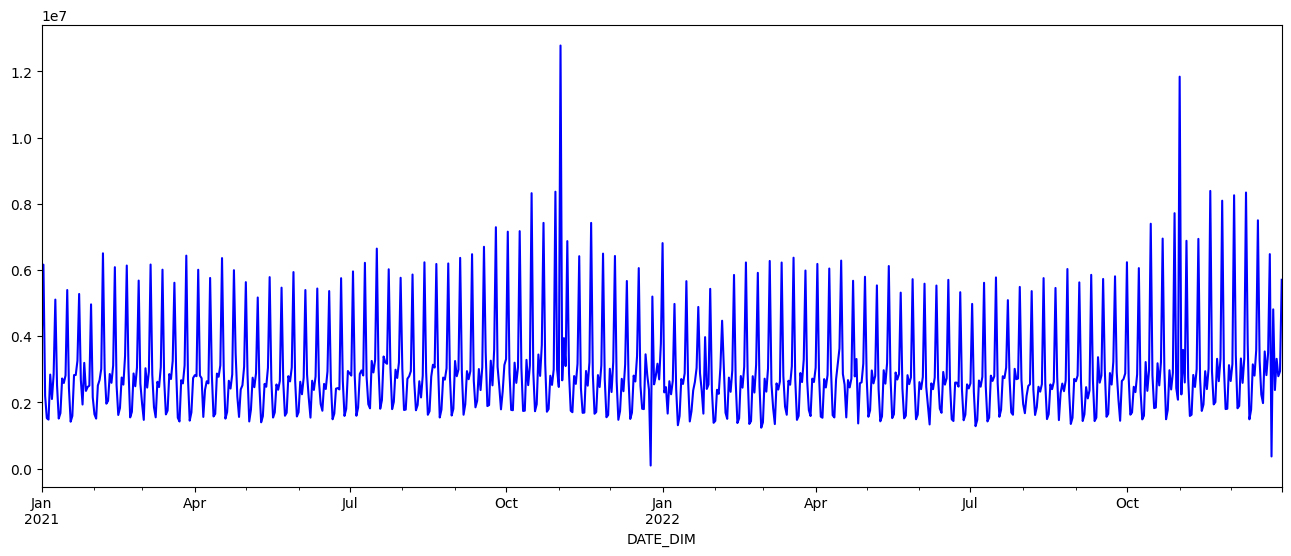

In [ ]:
plt.figure(figsize=(16,6))
df_day['TOTAL_TURNOVER'].plot(kind='line', color='b')

In [ ]:
data_end = int(np.floor(0.8*(df_day.shape[0])))
train = df_day[0:data_end]['TOTAL_TURNOVER']
train = train.values.reshape(-1)
test = df_day[data_end:]['TOTAL_TURNOVER'].values.reshape(-1)

In [ ]:
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train.reshape(-1, 1))
test_scaled = scaler.transform(test.reshape(-1, 1))

In [ ]:
def get_data(train,test,time_step,num_predict):
  x_train= list()
  y_train = list()
  x_test = list()
  y_test = list()

  for i in range(0,len(train) - time_step - num_predict):
    x_train.append(train[i:i+time_step])
    y_train.append(train[i+time_step:i+time_step+num_predict])

  for i in range(0, len(test) - time_step - num_predict):
    x_test.append(test[i:i+time_step])
    y_test.append(test[i+time_step:i+time_step+num_predict])

  return np.asarray(x_train), np.asarray(y_train), np.asarray(x_test), np.asarray(y_test)

In [ ]:
x_train, y_train, x_test, y_test = get_data(train,test,60,1)


x_train = x_train.reshape(-1,60)

x_train = scaler.fit_transform(x_train)
y_train = scaler.fit_transform(y_train)

x_test = x_test.reshape(-1,60)

x_test = scaler.fit_transform(x_test)
y_test = scaler.fit_transform(y_test)

In [ ]:
x_train = x_train.reshape(-1,60,1)
y_train = y_train.reshape(-1,1)

x_test = x_test.reshape(-1,60,1)
y_test = y_test.reshape(-1,1)

In [ ]:
n_input = 60
n_features = 1

model = Sequential()
model.add(LSTM(units=50,activation='relu', input_shape=(n_input, n_features), return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=60, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=60))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [ ]:
model.fit(x_train, y_train, batch_size=32, epochs=500, validation_split=0.2, verbose=1)
model.save('/content/driver/My Drive/Data-driven Business/LSTMmodel60_to_1forecast.h5')

Epoch 1/500
14/14 [==============================] - 11s 343ms/step - loss: 1.0758 - val_loss: 0.7220
Epoch 2/500
14/14 [==============================] - 2s 120ms/step - loss: 1.0737 - val_loss: 0.7333
Epoch 3/500
14/14 [==============================] - 2s 120ms/step - loss: 1.0680 - val_loss: 0.7211
Epoch 4/500
14/14 [==============================] - 2s 119ms/step - loss: 1.0697 - val_loss: 0.7225
Epoch 5/500
14/14 [==============================] - 2s 122ms/step - loss: 1.0719 - val_loss: 0.7434
Epoch 6/500
14/14 [==============================] - 2s 120ms/step - loss: 1.0687 - val_loss: 0.7325
Epoch 7/500
14/14 [==============================] - 2s 156ms/step - loss: 1.0638 - val_loss: 0.7217
Epoch 8/500
14/14 [==============================] - 3s 194ms/step - loss: 1.0689 - val_loss: 0.7225
Epoch 9/500
14/14 [==============================] - 2s 123ms/step - loss: 1.0763 - val_loss: 0.7294
Epoch 10/500
14/14 [==============================] - 2s 120ms/step - loss: 1.0655 - val_l

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 2s 29ms/step


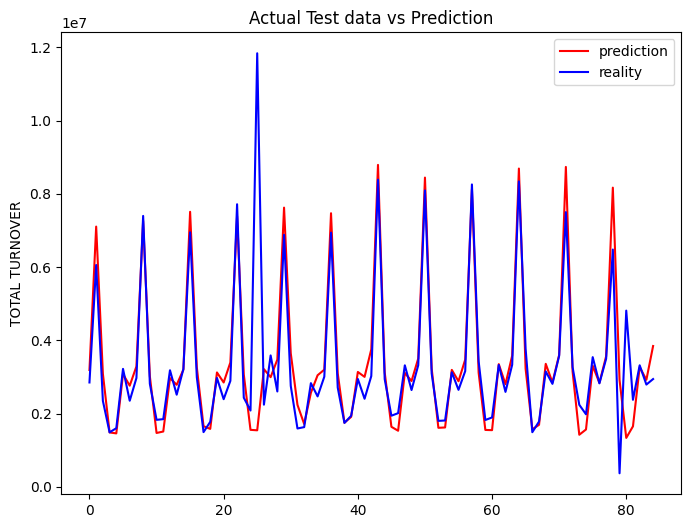

In [ ]:
model = keras.models.load_model('/content/driver/My Drive/Data-driven Business/LSTMmodel60_to_1forecast.h5')

test_output = model.predict(x_test)

from sklearn.metrics import mean_squared_error

test_mse_loss = mean_squared_error(y_test, test_output)

test_1 = scaler.inverse_transform(test_output)
test_2 = scaler.inverse_transform(y_test)

plt.figure(figsize=(8,6))
plt.plot(test_1, color='r')
plt.plot(test_2 ,color='b')
plt.title("Actual Test data vs Prediction")
plt.ylabel("TOTAL TURNOVER")
plt.legend(('prediction', 'reality'),loc='upper right')
plt.show()

In [ ]:
print("Mean Squared Error on Test set: " + str(test_mse_loss))

Mean Squared Error on Test set: 0.4039334961304545


17/17 [==============================] - 1s 33ms/step


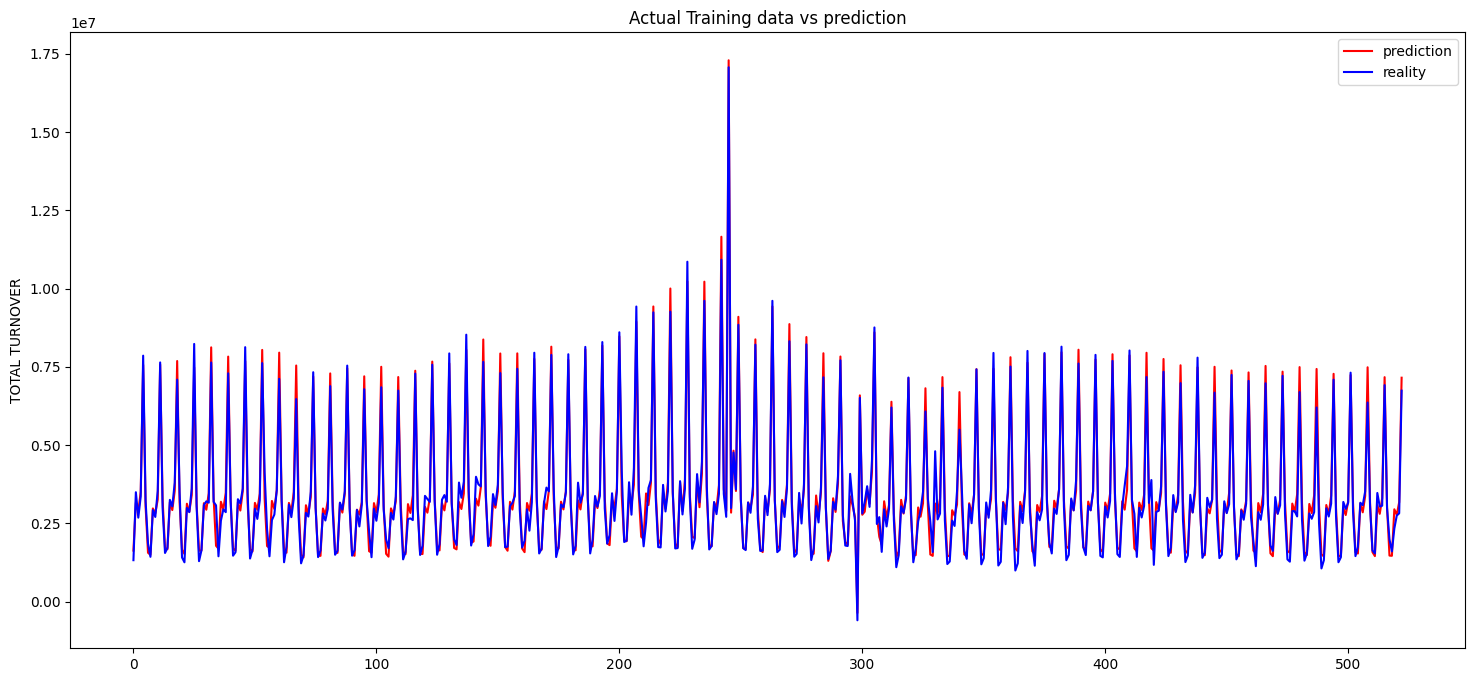

In [ ]:
test_output = model.predict(x_train)

train_1 = scaler.inverse_transform(test_output)
train_2 = scaler.inverse_transform(y_train)
plt.figure(figsize=(18,8))
plt.plot(train_1, color='r')
plt.plot(train_2 ,color='b')
plt.title("Actual Training data vs prediction")
plt.ylabel("TOTAL TURNOVER")
plt.legend(('prediction', 'reality'),loc='upper right')
plt.show()

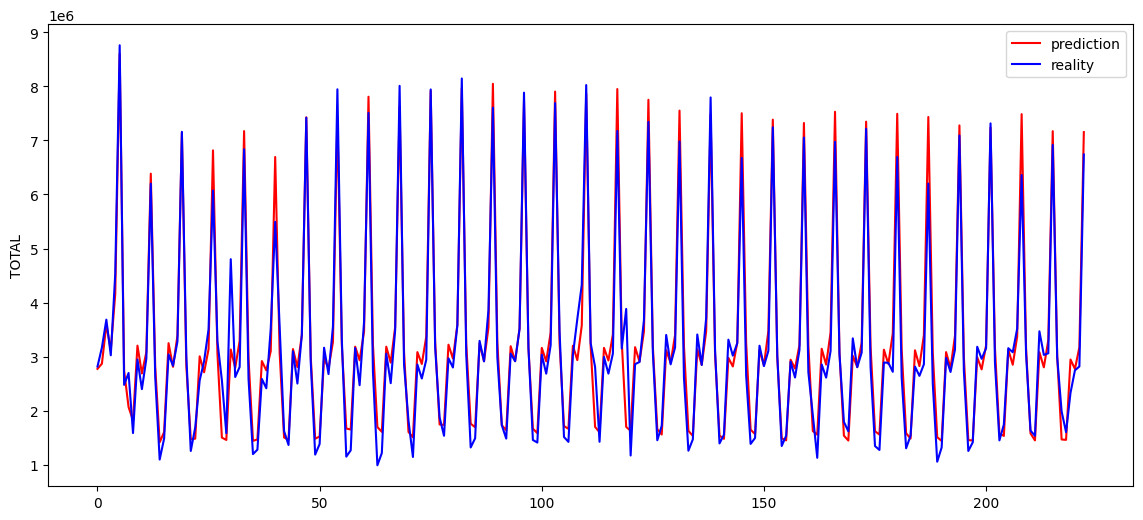

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(train_1[300:600], color='r')
plt.plot(train_2[300:600] ,color='b')
# plt.title("TOTAL TURNOVER")
plt.ylabel("TOTAL")
plt.legend(('prediction', 'reality'),loc='upper right')
plt.show()

#Forecast for the upcoming time based on previous data

In [ ]:
future_days = 30
last_sequence = train_scaled[-60:]
forecast = []
for _ in range(future_days):
    next_value = model.predict(last_sequence.reshape(1, 60, 1))
    forecast.append(next_value[0])
    last_sequence = np.append(last_sequence[1:], next_value, axis=0)


1/1 [==============================] - 0s 28ms/step


In [ ]:
forecast = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))

# Tạo index cho dự đoán
last_date = 730
# index = pd.date_range(start=last_date, periods=future_days+1, closed='right')
# index = index[1:]
index = pd.RangeIndex(start=last_date, stop=last_date+future_days, step=1)

# Tạo DataFrame cho dự đoán
forecast_df = pd.DataFrame(forecast, index=index, columns=['Forecast'])

# In kết quả
print(forecast_df)



        Forecast
730  1601458.125
731  1561765.375
732  3135409.750
733  2843500.250
734  3446226.000
735  7484924.500
736  3057397.250
737  1530011.125
738  1466133.375
739  2955723.750
740  2800287.500
741  3225298.500
742  7366005.000
743  3229445.250
744  1653003.750
745  1616383.125
746  3159892.000
747  2891040.000
748  3457402.250
749  7660281.500
750  3182655.250
751  1670490.875
752  1582511.125
753  3126587.000
754  2906226.250
755  3399307.000
756  7786402.000
757  3261380.250
758  1742898.250
759  1698102.625


In [ ]:
last_date = pd.to_datetime('2022-12-31')
index = pd.date_range(start=last_date, periods=future_days+1)
index = index[1:]


# Tạo DataFrame cho dự đoán
forecast_df = pd.DataFrame(forecast, index=index, columns=['Forecast'])


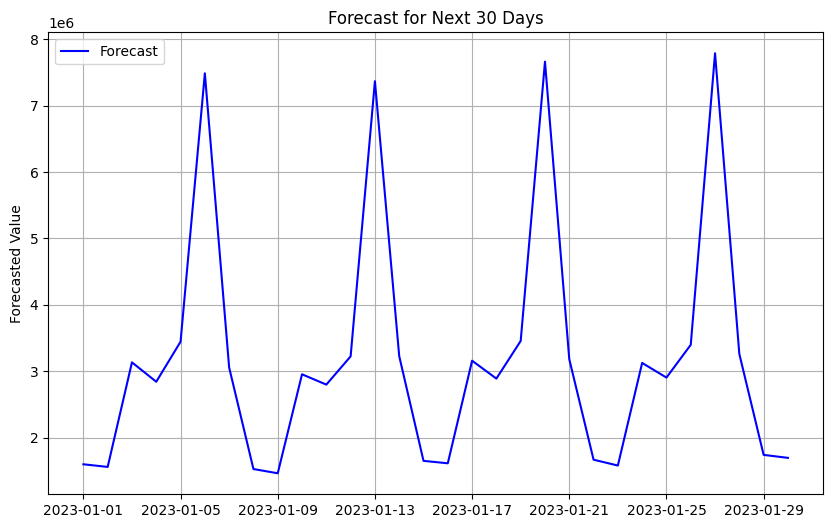

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecast', color='blue')
plt.ylabel('Forecasted Value')
plt.title('Forecast for Next 30 Days')
plt.legend()
plt.grid(True)
plt.show()

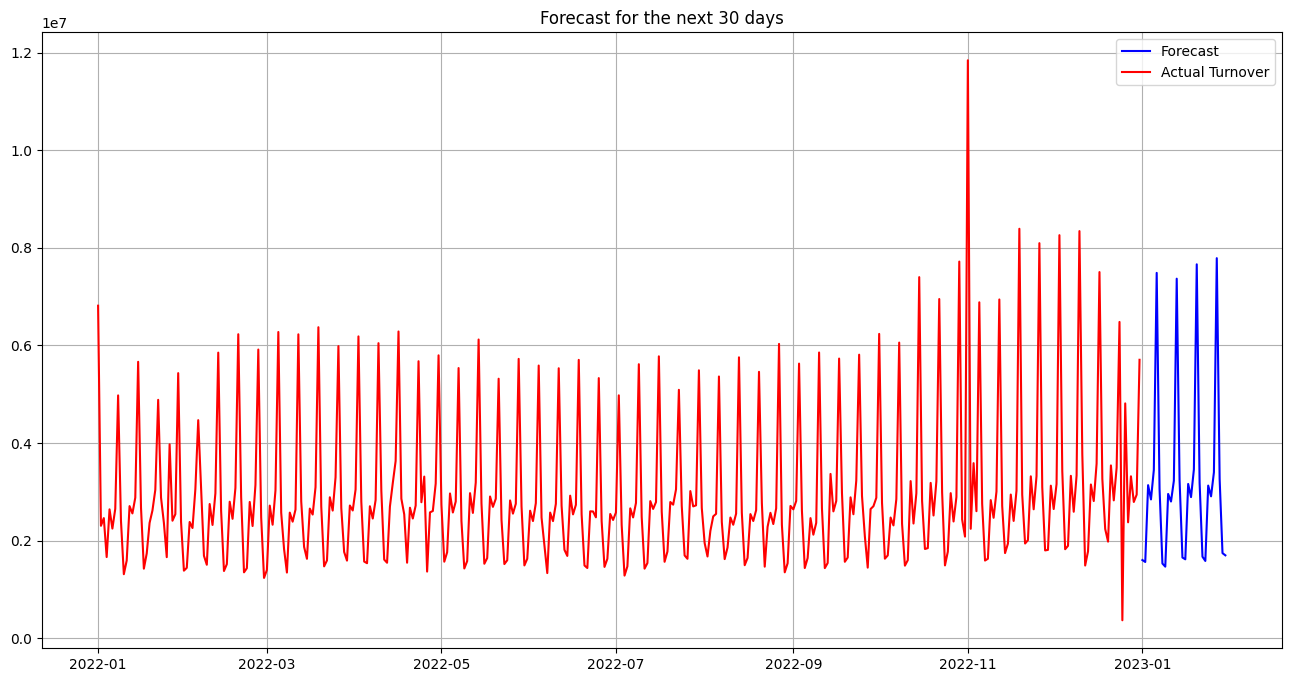

In [ ]:

actual_value = df_day.tail(365)

plt.figure(figsize=(16, 8))

# Vẽ đồ thị cho df1
plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecast', color='blue')

# # Vẽ đồ thị cho df2
plt.plot(actual_value.index, actual_value['TOTAL_TURNOVER'] , label='Actual Turnover', color='red')

plt.title("Forecast for the next 30 days")
plt.legend()
plt.grid(True)

# Hiển thị biểu đồ
plt.show()

# Forecast for the next 4 months

In [ ]:
future_days = 120
last_sequence = train_scaled[-60:]
forecast = []
for _ in range(future_days):
    next_value = model.predict(last_sequence.reshape(1, 60, 1))
    forecast.append(next_value[0])
    last_sequence = np.append(last_sequence[1:], next_value, axis=0)


1/1 [==============================] - 0s 63ms/step


In [ ]:
forecast = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))

last_date = pd.to_datetime('2022-12-31')
index = pd.date_range(start=last_date, periods=future_days+1)
index = index[1:]


# Tạo DataFrame cho dự đoán
forecast_df = pd.DataFrame(forecast, index=index, columns=['Forecast'])



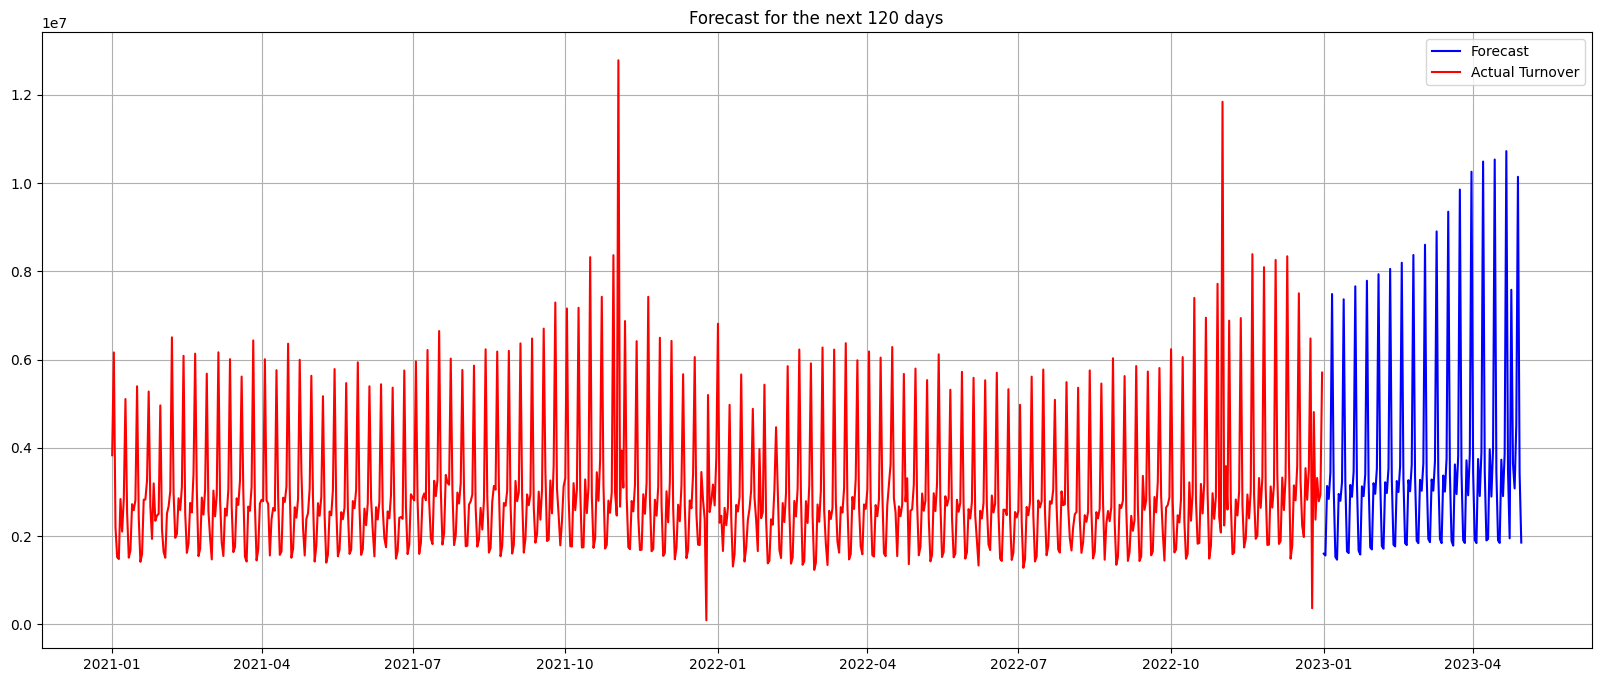

In [ ]:

actual_value = df_day

plt.figure(figsize=(20, 8))

plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecast', color='blue')

plt.plot(actual_value.index, actual_value['TOTAL_TURNOVER'] , label='Actual Turnover', color='red')


plt.title("Forecast for the next 120 days")
plt.legend()
plt.grid(True)

plt.show()

# Forecast and plot by month

In [ ]:
actual_value.reset_index(inplace=True)

In [ ]:
actual_value['MONTH'] = pd.to_datetime(actual_value['DATE_DIM']).dt.to_period('M')

actual_value_monthly = actual_value.groupby('MONTH').sum()

actual_value_monthly.reset_index(drop=True, inplace=True)

actual_value_monthly.index += 1

actual_value_monthly


TypeError: datetime64 type does not support sum operations

In [ ]:
forecast_df.reset_index(inplace=True)

In [ ]:
forecast_df['index'] = pd.to_datetime(forecast_df['index'])

# Create a new column 'MONTH' containing the month-year information
forecast_df['MONTH'] = forecast_df['index'].dt.to_period('M')

# Group by 'MONTH' and perform summation on other columns
# forecast_df_monthly = forecast_df.groupby('MONTH').sum()

# # Reset index to make 'MONTH' a regular column
# forecast_df_monthly.reset_index(inplace=True)

# # Adding 25 to the index
# forecast_df_monthly.index += 25

In [ ]:
forecast_df

,level_0,index,Forecast,MONTH
0,0,2023-01-01,1.601458e+06,2023-01
1,1,2023-01-02,1.561765e+06,2023-01
2,2,2023-01-03,3.135410e+06,2023-01
3,3,2023-01-04,2.843500e+06,2023-01
4,4,2023-01-05,3.446226e+06,2023-01
...,...,...,...,...
115,115,2023-04-26,3.080562e+06,2023-04
116,116,2023-04-27,4.528624e+06,2023-04
117,117,2023-04-28,1.014178e+07,2023-04
118,118,2023-04-29,3.424663e+06,2023-04


In [ ]:
forecast_df.groupby(['MONTH'])[['Forecast']].sum()

,Forecast
MONTH,
2023-01,99697272.0
2023-02,99403080.0
2023-03,123348720.0
2023-04,125036056.0


from matplotlib import pyplot as plt
_df_0['Forecast'].plot(kind='hist', bins=20, title='Forecast')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Forecast'].plot(kind='line', figsize=(8, 4), title='Forecast')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
plt.figure(figsize=(16, 8))

# Vẽ đồ thị cho df1
plt.plot(forecast_df_monthly.index, forecast_df_monthly['Forecast'], label='Forecast', color='blue')

# # Vẽ đồ thị cho df2
plt.plot(actual_value_monthly.index, actual_value_monthly['TOTAL_TURNOVER'] , label='Actual Turnover', color='red')

plt.legend()
plt.grid(True)

# Hiển thị biểu đồ
plt.show()